This notebook can be used to run the DINEOF algorithm (Beckers and Rixon, 2003) to infill over clouds for Landsat data. The csv Landsat scenes used were generated using the landsat_scenes notebook, and the product of this notebook are the scenes in the Infilled folder.

In [1]:
# imports
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
from datetime import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as sci
import numpy as np
import math
import csv
import random
import copy

# sets cloud cutoff and which Landsat data to process (5, 7, or 8)
index = 2
cloud_cutoff = 80
landsat_choices = ["landsat_5", "landsat_7", "landsat_8"]
date_choices = ["L5_dates", "L7_dates", "L8_dates"]
cloud_choices = ["L5_clouds", "L7_clouds", "L8_clouds"]
path = '/content/drive/MyDrive/Research/'

Mounted at /content/drive


# Creating Stacked Array

In [ ]:
# loads the list of dates, cloud cover percentages, and all csv scenes 
# for one landsat satellite

# file paths for the data
scene_path = path + 'landsat_scenes/csv_scenes/' + landsat_choices[index] + '/'
date_cloud_path = path + 'landsat_scenes/dates_clouds/'

# function that reads csv files
def readCSV(fpath, fname):
  file = open(fpath + fname + ".csv")
  csvreader = csv.reader(file)
  array = []
  for row in csvreader:
    array.append(row)
  return np.array(array)

# reads the csv files to arrays, all_scenes is a list of arrays, each
# entry representing a Landsat scene
dates = np.squeeze(readCSV(date_cloud_path, date_choices[index]), 1)
clouds = np.squeeze(readCSV(date_cloud_path, cloud_choices[index]), 1).astype(float)
scene_size = np.shape(readCSV(scene_path, dates[0]))
all_scenes = np.zeros([len(dates), scene_size[0], scene_size[1]])
for i in range(len(dates)):
  print("Scene " + str(i+1) + " of " + str(len(dates)))
  scene = readCSV(scene_path, dates[i]).astype(float)
  all_scenes[i] = scene

In [ ]:
# finds a cloudless scene in the catalog and records all of the water pixels

# finds and displays a cloudless scene, uses a scene without scanline error
# for Landsat 7
if index == 0 or index == 2:
  no_clouds = all_scenes[np.argmin(16)]
else:
  no_clouds = readCSV(path + 'landsat_scenes/csv_scenes/', "1999-10-27_full").astype(float)
plt.figure(figsize = (5,10))
plt.imshow(no_clouds);

# finds and saves all of the water indices (pixels that are non nan)
water_indices = []
rows = np.shape(no_clouds)[0]
cols = np.shape(no_clouds)[1]
for j in range(cols):
  for i in range(rows):
    if not math.isnan(no_clouds[i][j]):
      water_indices.append([i,j])
water_indices = np.array(water_indices)

# uncomment the line corresponding to the current landsat satellite
# %cd '/content/drive/MyDrive/Research/dineof_scenes/landsat_5'
%cd '/content/drive/MyDrive/Research/dineof_scenes/landsat_7'
# %cd '/content/drive/MyDrive/Research/dineof_scenes/landsat_8'
np.savetxt(landsat_choices[index] + "_water_pixels.csv", water_indices, delimiter=",")

In [ ]:
# flattens all of the scenes to 1d arrays containing only the water pixels
# and puts them all into one big array where columns are flattened scenes

# flattens and saves the scenes
stacked_scenes = np.zeros([np.shape(water_indices)[0], len(dates)])
for i in range(len(dates)):
  print("Scene " + str(i+1) + " of " + str(len(dates)))
  current_scene = all_scenes[i]
  flat_scene = np.zeros(np.shape(water_indices)[0])
  for j in range(np.shape(flat_scene)[0]):
    value = current_scene[water_indices[j][0]][water_indices[j][1]]
    flat_scene[j] = value
  stacked_scenes[:,i] = flat_scene

# uncomment the line corresponding to the current landsat satellite
# %cd '/content/drive/MyDrive/Research/dineof_scenes/landsat_5'
%cd '/content/drive/MyDrive/Research/dineof_scenes/landsat_7'
# %cd '/content/drive/MyDrive/Research/dineof_scenes/landsat_8'
np.savetxt(landsat_choices[index] + "_stacked.csv", stacked_scenes, delimiter=",")

# DINEOF Algorithm

In [ ]:
# loads the dates and clouds array for one landsat satellite, as well
# as the stacked scenes array, filters by cloud cutoff

# file path for the date and cloud data
fpath = path + 'landsat_scenes/dates_clouds/'

# function that reads csv files
def readCSV(fname):
  file = open(fpath + fname + ".csv")
  csvreader = csv.reader(file)
  array = []
  for row in csvreader:
    array.append(row)
  return np.array(array)

# loads the dates and clouds arrays
dates = np.squeeze(readCSV(date_choices[index]), 1)
clouds = np.squeeze(readCSV(cloud_choices[index]), 1).astype(float)

# file path for the stacked scenes data
fpath = path + 'dineof_scenes/' + landsat_choices[index] + '/'
sizes = [[444819,410], [446191,411], [446401,169]]
stacked_scenes = np.zeros(sizes[index])

# function that reads csv files
def readCSV(fname):
  file = open(fpath + fname + ".csv")
  csvreader = csv.reader(file)
  i = 0
  for row in csvreader:
    stacked_scenes[i,:] = row
    i += 1

# loads the stacked scenes
readCSV(landsat_choices[index] + "_stacked")
dates_filtered = dates[np.nonzero(clouds < cloud_cutoff)]
clouds_filtered = clouds[np.nonzero(clouds < cloud_cutoff)]
stacked_scenes = np.squeeze(stacked_scenes[:, np.nonzero(clouds < cloud_cutoff)], 1)

# uncomment the line corresponding to the current landsat satellite
# %cd '/content/drive/MyDrive/Research/dineof_scenes/landsat_5'
%cd '/content/drive/MyDrive/Research/dineof_scenes/landsat_7'
# %cd '/content/drive/MyDrive/Research/dineof_scenes/landsat_8'
np.savetxt(landsat_choices[index] + "_filtered_dates.csv", dates_filtered, delimiter=",", fmt='%s')
np.savetxt(landsat_choices[index] + "_filtered_clouds.csv", clouds_filtered, delimiter=",")

/content/drive/MyDrive/Research/dineof_scenes/landsat_7


In [ ]:
# finds the indices of stacked array with nan values (aka clouds) and
# finds the number of nans in each column, sets cloud pixels equal to
# mean of the data (initial guess)

# finds the mean of the data
mean = np.nanmean(stacked_scenes)

# finds the cloud indices and tracks the number of clouds in each column
rows = np.shape(stacked_scenes)[0]
cols = np.shape(stacked_scenes)[1]
cloud_indices = []
cloud_tracker = np.zeros(np.shape(stacked_scenes)[1])
for j in range(cols):
  count = 0
  for i in range(rows):
    if math.isnan(stacked_scenes[i,j]):
      stacked_scenes[i,j] = mean
      cloud_indices.append([i,j])
      count += 1
  cloud_tracker[j] = count     

In [ ]:
# picks some random columns with fewer than 1000 cloud pixels for testing and
# sets a number of random entries in each column to the mean of the data, these
# are the test clouds

# sets the number of error columns and the number of error points
num_cols = 15
error_size = 200000

# finds some random columns with fewer than 1000 cloud pixels and stores those
# columns in the error_cols array
error_col_indices = random.sample(list(np.where(cloud_tracker < 5000)[0]), num_cols)
error_cols = np.zeros([np.shape(stacked_scenes)[0],num_cols])
for i in range(num_cols):
  error_cols[:,i] = stacked_scenes[:,error_col_indices[i]]

# makes a copy of error_cols that will will use as ground truth
error_cols_truth = copy.deepcopy(error_cols)

# creates an array that will store the indices of the added clouds
cloud_indices_error = np.zeros([error_size,num_cols])

# finds and stores the incides in the error columns without clouds,
# chooses a random number of these indices to set to clouds
for i in range(num_cols):
  curr_col = error_cols[:,i]
  noncloud_indices = np.squeeze(np.transpose(np.where(curr_col != mean)),1)
  sample_indices = np.random.choice(noncloud_indices, error_size, replace=False)
  cloud_indices_error[:,i] = sample_indices

# sets the indices found above to the mean of the data, the fake clouds
print(np.count_nonzero(error_cols == mean))
for i in range(num_cols):
  curr_col = cloud_indices_error[:,i].astype(int)
  error_cols[curr_col,i] = mean
print(np.count_nonzero(error_cols == mean))

# appends these error columns onto the end of stacked_scenes
stacked_scenes_error = np.zeros([np.shape(stacked_scenes)[0], np.shape(stacked_scenes)[1] + num_cols])
stacked_scenes_error[:,:np.shape(stacked_scenes)[1]] = stacked_scenes
stacked_scenes_error[:,np.shape(stacked_scenes)[1]:] = error_cols

20821
3020821


In [ ]:
# all of the pieces needed for the dineof algorithm

# the original stacked scenes array
stacked_scenes_dineof = stacked_scenes
print("stacked scenes:")
print(np.shape(stacked_scenes_dineof))

# the original stacked scenes array with some number of error columns with
# fake clouds added
stacked_scenes_error_dineof = stacked_scenes_error
print("stacked scenes with error columns tacked on:")
print(np.shape(stacked_scenes_error_dineof))

# the truth for the error columns, no fake clouds
error_cols_truth_dineof = error_cols_truth
print("ground truth to test error columns against:")
print(np.shape(error_cols_truth_dineof))

# the list of indices where cloud pixels are in the main stacked scenes array
cloud_indices_dineof = np.array(cloud_indices)
print("list of indices where clouds are in main array:")
print(np.shape(cloud_indices_dineof))

# the list of indices where cloud pixels are in the error columns
cloud_indices_error_dineof = []
for i in range(np.shape(cloud_indices_error)[0]):
  for j in range(np.shape(cloud_indices_error)[1]):
    row = cloud_indices_error[i,j]
    col = np.shape(stacked_scenes)[1] + j
    cloud_indices_error_dineof.append([row,col])
cloud_indices_error_dineof = np.array(cloud_indices_error_dineof).astype(int)
print("list of indices where clouds are in error columns:")
print(np.shape(cloud_indices_error_dineof))

stacked scenes:
(446191, 326)
stacked scenes with error columns tacked on:
(446191, 341)
ground truth to test error columns against:
(446191, 15)
list of indices where clouds are in main array:
(37499252, 2)
list of indices where clouds are in error columns:
(3000000, 2)


In [ ]:
# calculates the mean squared error between the ground truth and
# the reconstruction

# function for calculating error
def calculate_error(recon):
  rows = cloud_indices_error_dineof[:,0]
  cols = cloud_indices_error_dineof[:,1]
  recon_error_subset = recon[rows,cols]
  error_cols_truth_dineof_subset = error_cols_truth_dineof[rows, cols-np.shape(stacked_scenes_dineof)[1]]
  return np.mean((np.square(recon_error_subset - error_cols_truth_dineof_subset)))

# sets the number of modes and error tolterance, calculates initial error
error_tol = 0.95
prev_error = 999999
print("Initial Error: " + str(calculate_error(stacked_scenes_error_dineof)))
total_modes = 9
errors = np.zeros(total_modes)
predictions = np.zeros([total_modes, np.shape(cloud_indices_error_dineof)[0]])
array_to_save = None
global_prev_error = 999999

# loops through the number of modes
for i in range(total_modes):
  num_modes = i+1
  print("-------------------------")
  print("Number of Modes: " + str(num_modes))
  array_to_update = copy.deepcopy(stacked_scenes_error_dineof)
  iteration = 1
  prev_error = 999999
  curr_error = calculate_error(stacked_scenes_error_dineof)
  # loops a certain number of times
  while curr_error/prev_error < error_tol:
    print("Iteration " + str(iteration))
    # takes the svd and truncates the modes
    u, s, v = np.linalg.svd(array_to_update, full_matrices=False)
    s = np.diag(s)
    u[:,num_modes:] = 0
    s[:,num_modes:] = 0
    v[num_modes:,:] = 0
    # reconstructs the original array with truncated modes
    reconstruction = np.matmul(np.matmul(u, s), v)
    # updates the array at the cloud locations, real and fake
    array_to_update[tuple(cloud_indices_dineof.T)] = reconstruction[tuple(cloud_indices_dineof.T)]
    array_to_update[tuple(cloud_indices_error_dineof.T)] = reconstruction[tuple(cloud_indices_error_dineof.T)]
    # calculates the error after reconstruction
    prev_error = curr_error
    curr_error = calculate_error(array_to_update)
    print("Error: " + str(curr_error))
    iteration += 1
  # stores the error and the prediction after the while loop is broken
  errors[i] = curr_error
  for j in range(np.shape(cloud_indices_error_dineof)[0]):
    row = cloud_indices_error_dineof[j][0]
    col = cloud_indices_error_dineof[j][1]
    predictions[i,j] = array_to_update[row,col]
  # if the current error is less than the previous error, update the array
  if curr_error < global_prev_error:
    print("Updating array to save")
    array_to_save = array_to_update
    global_prev_error = curr_error
  else:
    break
  print("-------------------------")

# uncomment the line corresponding to the current landsat satellite
# %cd '/content/drive/MyDrive/Research/dineof_scenes/landsat_5'
%cd '/content/drive/MyDrive/Research/dineof_scenes/landsat_7'
# %cd '/content/drive/MyDrive/Research/dineof_scenes/landsat_8'
np.savetxt(landsat_choices[index] + "_dineof_error.csv", errors, delimiter=",")
np.savetxt(landsat_choices[index] + "_dineof_predictions.csv", predictions, delimiter=",")
np.savetxt(landsat_choices[index] + "_dineof_stacked.csv", array_to_save, delimiter=",")

Initial Error: 48.420784620398074
-------------------------
Number of Modes: 1
Iteration 1
Error: 10.749874980376608
Iteration 2


# Plotting DINEOF Results

In [ ]:
# loads the error and predictions for the fake clouds at each mode iteration

# file path for the error and prediction data
fpath = path + 'dineof_scenes/' + landsat_choices[index] + '/'

# function that reads csv files
def readCSV(fname):
  file = open(fpath + fname + ".csv")
  csvreader = csv.reader(file)
  array = []
  for row in csvreader:
    array.append(row)
  return np.array(array)

# loads the error and prediction data
error_dineof = readCSV(landsat_choices[index] + "_dineof_error").astype(float)
predictions_dineof = readCSV(landsat_choices[index] + "_dineof_predictions").astype(float)

In [ ]:
# plots the truth versus precited values for each mode iteration

# loads the true values, before adding fake clouds
truth = np.zeros(np.shape(cloud_indices_error_dineof)[0])
for i in range(np.shape(cloud_indices_error_dineof)[0]):
  row = cloud_indices_error_dineof[i][0]
  col = cloud_indices_error_dineof[i][1]
  truth[i] = error_cols_truth_dineof[row, col-np.shape(stacked_scenes_dineof)[1]]

# plots the predictions at each mode iteration
fig, axs = plt.subplots(3, 3);
fig.tight_layout(pad=0.3)
fig.set_figheight(10)
fig.set_figwidth(18)

axs[0,0].scatter(truth, predictions_dineof[0,:]);
axs[0,0].plot([0,35],[0,35], c='black', lw=3);
axs[0,0].set(xlabel="truth", ylabel="prediction", title="Num Modes = 1", xlim=[-3,40], ylim=[-3,40]);

axs[0,1].scatter(truth, predictions_dineof[1,:]);
axs[0,1].plot([0,35],[0,35], c='black', lw=3);
axs[0,1].set(xlabel="truth", ylabel="prediction", title="Num Modes = 2", xlim=[-3,40], ylim=[-3,40]);

axs[0,2].scatter(truth, predictions_dineof[2,:]);
axs[0,2].plot([0,35],[0,35], c='black', lw=3);
axs[0,2].set(xlabel="truth", ylabel="prediction", title="Num Modes = 3", xlim=[-3,40], ylim=[-3,40]);

axs[1,0].scatter(truth, predictions_dineof[3,:]);
axs[1,0].plot([0,35],[0,35], c='black', lw=3);
axs[1,0].set(xlabel="truth", ylabel="prediction", title="Num Modes = 4", xlim=[-3,40], ylim=[-3,40]);

axs[1,1].scatter(truth, predictions_dineof[4,:]);
axs[1,1].plot([0,35],[0,35], c='black', lw=3);
axs[1,1].set(xlabel="truth", ylabel="prediction", title="Num Modes = 5", xlim=[-3,40], ylim=[-3,40]);

axs[1,2].scatter(truth, predictions_dineof[5,:]);
axs[1,2].plot([0,35],[0,35], c='black', lw=3);
axs[1,2].set(xlabel="truth", ylabel="prediction", title="Num Modes = 6", xlim=[-3,40], ylim=[-3,40]);

axs[2,0].scatter(truth, predictions_dineof[6,:]);
axs[2,0].plot([0,35],[0,35], c='black', lw=3);
axs[2,0].set(xlabel="truth", ylabel="prediction", title="Num Modes = 7", xlim=[-3,40], ylim=[-3,40]);

axs[2,1].scatter(truth, predictions_dineof[7,:]);
axs[2,1].plot([0,35],[0,35], c='black', lw=3);
axs[2,1].set(xlabel="truth", ylabel="prediction", title="Num Modes = 8", xlim=[-3,40], ylim=[-3,40]);

axs[2,2].scatter(truth, predictions_dineof[8,:]);
axs[2,2].plot([0,35],[0,35], c='black', lw=3);
axs[2,2].set(xlabel="truth", ylabel="prediction", title="Num Modes = 9", xlim=[-3,40], ylim=[-3,40]);

NameError: ignored

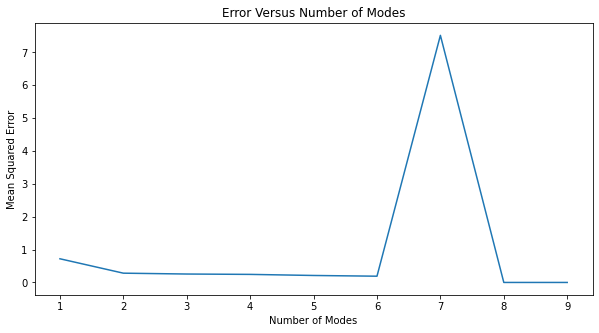

In [ ]:
# plots the error at each mode iteration
modes = np.arange(total_modes)+1
plt.figure(figsize = (10,5));
plt.plot(modes, error_dineof);
plt.title("Error Versus Number of Modes");
plt.xlabel("Number of Modes");
plt.ylabel("Mean Squared Error");

# Reconstructing Scenes

In [ ]:
# loads the filtered dates, the water indices, and the array of stacked
# scenes produces by the dineof algorithm

# file path for the filtered dates, water indices, and dineof stacked scenes
fpath = path + 'dineof_scenes/' + landsat_choices[index] + '/'
sizes1 = [[444819,326], [446191,341], [446401, 142]]
sizes2 = [[444819,311], [446191,326], [446401, 127]]

# function that reads csv files
def readCSV(fname):
  file = open(fpath + fname + ".csv")
  csvreader = csv.reader(file)
  array = []
  for row in csvreader:
    array.append(row)
  return np.array(array)

# loads the filtered dates and water indices data, creates an empty stacked
# array to fill
filtered_dates = np.squeeze(readCSV(landsat_choices[index] + "_filtered_dates"), 1)
water_indices = readCSV(landsat_choices[index] + "_water_pixels").astype(float)
stacked_dineof = np.zeros(sizes1[index])

# function that reads csv files
def readCSV(fname):
  file = open(fpath + fname + ".csv")
  csvreader = csv.reader(file)
  i = 0
  for row in csvreader:
    stacked_dineof[i,:] = row
    i += 1

# loads the dineof stacked scenes
readCSV(landsat_choices[index] + "_dineof_stacked")
stacked_dineof = stacked_dineof[:,:sizes2[index][1]]

In [ ]:
# reconstructs each scene and saves it as a csv file
# uncomment the line corresponding to the current landsat satellite
# %cd '/content/drive/MyDrive/Research/dineof_scenes/landsat_5/scenes'
%cd '/content/drive/MyDrive/Research/dineof_scenes/landsat_7/scenes'
# %cd '/content/drive/MyDrive/Research/dineof_scenes/landsat_8/scenes'

# loops through each column in the stacked scene array and unflattens it
# using the saved water indices
sizes = [[1130,800], [1130,800], [1130,800]]
for i in range(np.shape(filtered_dates)[0]):
  print("Scene " + str(i+1) + " of " + str(np.shape(filtered_dates)[0]))
  flat_scene = stacked_dineof[:,i]
  regular_scene = np.zeros([sizes[index][0], sizes[index][1]])
  regular_scene[:,:] = np.nan
  for j in range(np.shape(water_indices)[0]):
    regular_scene[water_indices[j,0].astype(int), water_indices[j,1].astype(int)] = flat_scene[j]
  np.savetxt(filtered_dates[i] + ".csv", regular_scene, delimiter=",")

# Error (Saving Data)

In [ ]:
# loads the cloud and filtered dates arrays, as well as the regular scenes
# and the dineof reconstructed scenes

# paths to the data
path1 = path + 'dineof_scenes/' + landsat_choices[index] + '/scenes/'
path2 = path + 'dineof_scenes/' + landsat_choices[index] + '/'
path3 = path + 'landsat_scenes/csv_scenes/' + landsat_choices[index] + '/'
path4 = path + 'landsat_scenes/dates_clouds/'

# function that reads csv files
def readCSV(fpath, fname):
  file = open(fpath + fname + ".csv")
  csvreader = csv.reader(file)
  array = []
  for row in csvreader:
    array.append(row)
  return np.array(array)

# loads the cloud and filtered dates data
sizes = [[1130,800], [1130,800], [1130,800]]
clouds = np.squeeze(readCSV(path4, cloud_choices[index]), 1).astype(float)
clouds = clouds[np.nonzero(clouds < cloud_cutoff)]
filtered_dates = np.squeeze(readCSV(path2, landsat_choices[index] + "_filtered_dates"), 1)
all_dineof_scenes = np.zeros([np.shape(filtered_dates)[0], sizes[index][0], sizes[index][1]])
all_scenes = np.zeros([np.shape(filtered_dates)[0], sizes[index][0], sizes[index][1]])

# function that reads csv files
def readCSV(fpath, fname):
  file = open(fpath + fname + ".csv")
  csvreader = csv.reader(file)
  scene = np.zeros([sizes[index][0], sizes[index][1]])
  i = 0
  for row in csvreader:
    scene[i,:] = row
    i += 1
  return scene

# loads the regular and dineof reconstructed scenes
for i in range(len(filtered_dates)):
  print("Scene " + str(i+1) + " of " + str(len(filtered_dates)))
  scene = readCSV(path3, filtered_dates[i]).astype(float)
  all_scenes[i,:,:] = scene
  dineof_scene = readCSV(path1, filtered_dates[i]).astype(float)
  all_dineof_scenes[i,:,:] = dineof_scene

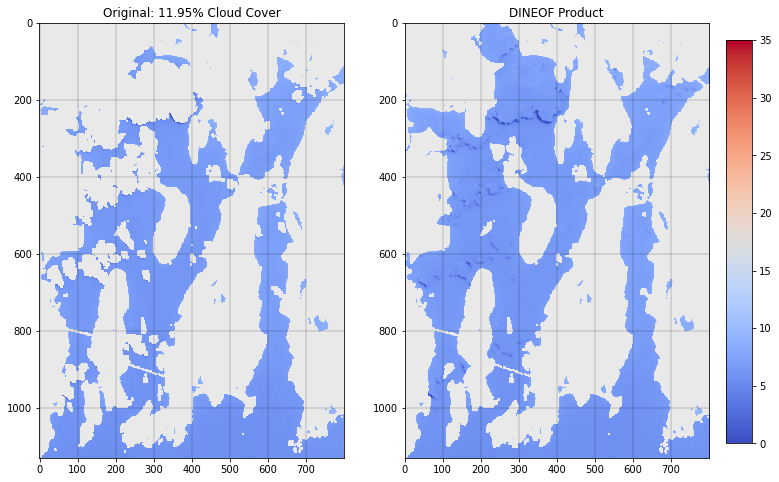

In [ ]:
# plots a regular scene and its cloudless counterpart
scene_num = 42
cmap = plt.cm.coolwarm
cmap.set_bad(color='lightgrey', alpha=0.5)
fig, ax = plt.subplots(1, 2, figsize = (12, 8))
im = ax[0].imshow(all_scenes[scene_num], cmap=cmap, aspect='auto', vmin=0, vmax=35)
ax[0].grid(lw=0.2, color="black")
ax[0].set_title("Original: " + str(clouds[scene_num]) + "% Cloud Cover")
im = ax[1].imshow(all_dineof_scenes[scene_num], cmap=cmap, aspect='auto', vmin=0, vmax=35)
ax[1].grid(lw=0.2, color="black")
ax[1].set_title("DINEOF Product")
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
fig.colorbar(im, cax=cbar_ax);

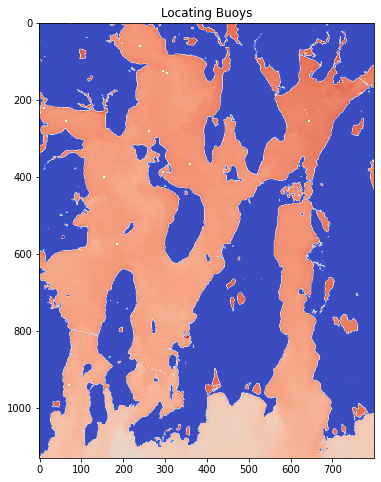

In [ ]:
# locates the position of the buoys (could be more accurate on this)

# makes a copy of a cloudless scene
scene = copy.deepcopy(all_dineof_scenes[0])
scene = np.nan_to_num(scene)

# buoy locations
scene[60,240] = np.nan
scene[125,295] = np.nan
scene[130,305] = np.nan
scene[220,12] = np.nan
scene[255,65] = np.nan
scene[280,263] = np.nan
scene[255,645] = np.nan
scene[365,360] = np.nan
scene[400,155] = np.nan
scene[386,295] = np.nan
scene[573,185] = np.nan
scene[940,70] = np.nan

# plots the scene and the buoys (represented by white pixels)
fig, ax = plt.subplots(1, 1, figsize = (6,8))
cmap = plt.cm.coolwarm
cmap.set_bad(color='white', alpha=0.5)
im = ax.imshow(scene, cmap=cmap, aspect='auto', vmin=0, vmax=35)
ax.set_title("Locating Buoys");

In [ ]:
# loads the buoy data

# file path for the buoy data
fpath = path + 'buoy_data/'
buoys = ["bid2", "bid3", "bid4", "bid5", "bid6", "bid7",
          "bid8", "bid9", "bid10", "bid15", "bid16", "bid17"]
all_buoy_data = []

# function that reads csv files
def readCSV(buoy):
  file = open(fpath + buoy + ".csv")
  csvreader = csv.reader(file)
  buoy_data = []
  count = 0
  for row in csvreader:
    if count != 0 and count != 1:
      row[3] = convert_time(row[3])
      buoy_data.append(row[2:4])
    count += 1
  buoy_data = np.array(buoy_data)
  all_buoy_data.append(buoy_data)

# function that converts time from date/time to poxis time
def convert_time(time):
  date = time[0:10]
  time = time[11:19]
  stamp = dt.strptime(date + " " + time, '%Y-%m-%d %H:%M:%S').timestamp()
  return(stamp)

# loads the buoy data
for buoy in buoys:
  readCSV(buoy)
for i in range(len(buoys)):
  all_buoy_data[i] = all_buoy_data[i].astype(float)

In [ ]:
# takes temporal averages of the buoy data centered around when Landsat
# scenes were taken, and spatial averages of the Landsat data centered
# around the buoy locations

# creates the data structures
buoy_locations = [[60,240], [125,295], [130,305], [220,12], [255,65], [280,263], [255,645], [365,360], [400,155], [386,295], [573,185], [940,70]]
num_buoys = len(buoy_locations)
num_dates = np.shape(filtered_dates)[0]
buoy_data = np.zeros([num_buoys, num_dates])
dineof_data = np.zeros([num_buoys, num_dates])

# function that takes a spatial average of a Landsat scene
def spatial_average(scene):
  averages = np.zeros(num_buoys)
  for i in range(num_buoys):
    buoy_location = buoy_locations[i]
    buoy_x = buoy_location[0]
    buoy_y = buoy_location[1]
    averages[i] = np.nanmean(scene[buoy_x-2:buoy_x+3, buoy_y-2:buoy_y+3])
  return averages

# function that takes a temporal average of buoy data
def temporal_average(date):
  stamp = convert_time(date + ".15:15:00.")
  averages = np.empty(num_buoys)*np.nan
  for i in range(num_buoys):
    times = all_buoy_data[i][:,1]
    time_differences = np.abs(times - stamp)
    if (np.amin(time_differences) < 15*60):
      min_index = np.argmin(time_differences)
      temps = all_buoy_data[i][:,0]
      temps_subset = temps[min_index-2:min_index+3]
      averages[i] = np.nanmean(temps_subset)
  return averages

# function that converts time from date/time to poxis time
def convert_time(time):
  date = time[0:10]
  time = time[11:19]
  stamp = dt.strptime(date + " " + time, '%Y-%m-%d %H:%M:%S').timestamp()
  return(stamp)

# fills in the data structures with the temporal and spatial averages
for i in range(num_dates):
  scene = all_dineof_scenes[i,:,:]
  dineof_data[:,i] = spatial_average(scene)
  buoy_data[:,i] = temporal_average(filtered_dates[i])

# uncomment the line corresponding to the current landsat satellite
# %cd '/content/drive/MyDrive/Research/dineof_scenes/landsat_5'
%cd '/content/drive/MyDrive/Research/dineof_scenes/landsat_7'
# %cd '/content/drive/MyDrive/Research/dineof_scenes/landsat_8'
np.savetxt(landsat_choices[index] + "_temp_data" + ".csv", dineof_data, delimiter=",")
np.savetxt(landsat_choices[index] + "_buoy_data" + ".csv", buoy_data, delimiter=",")

<ipython-input-12-175809d9e64b>:33: RuntimeWarning: Mean of empty slice
  averages[i] = np.nanmean(temps_subset)


/content/drive/MyDrive/Research/dineof_scenes/landsat_7


# Error (Analyzing Individual Satellite Data)

In [ ]:
# path to the data
fpath = path + 'dineof_scenes/' + landsat_choices[index] + '/'

# function that reads csv files
def readCSV(fname):
  file = open(fpath + fname + ".csv")
  csvreader = csv.reader(file)
  array = []
  for row in csvreader:
    array.append(row)
  return np.array(array)

landsat_data = readCSV(landsat_choices[index] + "_temp_data").astype(float)
buoy_data = readCSV(landsat_choices[index] + "_buoy_data").astype(float)

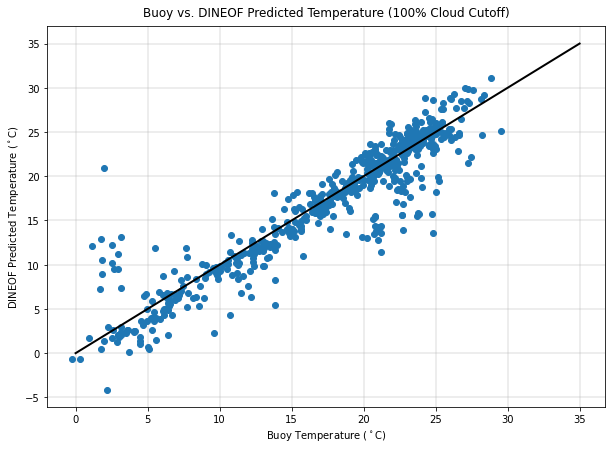

In [ ]:
# plots the dineof predicted data versus the buoy data

# filters by cloud cutoff and plots
plot_cloud_cutoff = 100
buoy_data_filtered = np.squeeze(buoy_data[:, np.nonzero(clouds < plot_cloud_cutoff)],1)
dineof_data_filtered = np.squeeze(landsat_data[:, np.nonzero(clouds < plot_cloud_cutoff)],1)
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(buoy_data_filtered, dineof_data_filtered);
ax.plot([0,35],[0,35], c='black', lw=2);
plt.title("Buoy vs. DINEOF Predicted Temperature (" + str(plot_cloud_cutoff) + "% Cloud Cutoff)", pad = 10);
plt.xlabel("Buoy Temperature ($^\circ$C)");
plt.ylabel("DINEOF Predicted Temperature ($^\circ$C)");
ax.set_axisbelow(True)
plt.grid(lw=0.45)

Mean: 0.4323849384259644
Standard Deviation: 2.6848770070137715
Skewness: -0.42530972347590756
Kurtosis: 7.310391581407229


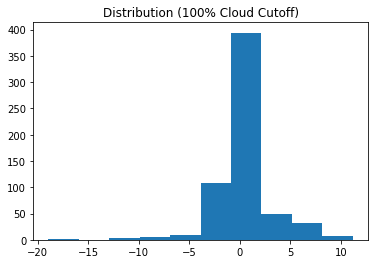

In [ ]:
# calculates statistics for the difference between the predicted dineof
# data and the buoy data

# filters by cloud cutoff and calculates statistics
buoy_data_filtered = np.squeeze(buoy_data[:, np.nonzero(clouds < plot_cloud_cutoff)],1)
dineof_data_filtered = np.squeeze(landsat_data[:, np.nonzero(clouds < plot_cloud_cutoff)],1)
difference = (buoy_data_filtered-dineof_data_filtered).flatten()
mean_val = np.nanmean(difference)
std_val = np.nanstd(difference)
skew_val = sci.skew(difference, nan_policy='omit')
kurtosis_val = sci.kurtosis(difference, nan_policy='omit')
print('Mean: ' + str(mean_val))
print('Standard Deviation: ' + str(std_val))
print('Skewness: ' + str(skew_val))
print('Kurtosis: ' + str(kurtosis_val))
plt.hist(difference)
plt.title('Distribution (' + str(plot_cloud_cutoff) + "% Cloud Cutoff)");

# Error (Analyzing All Satellite Data)

In [2]:
# path to the data
fpath1 = path + 'dineof_scenes/landsat_5/'
fpath2 = path + 'dineof_scenes/landsat_7/'
fpath3 = path + 'dineof_scenes/landsat_8/'

# function that reads csv files
def readCSV(fpath, fname):
  file = open(fpath + fname + ".csv")
  csvreader = csv.reader(file)
  array = []
  for row in csvreader:
    array.append(row)
  return np.array(array)

# loads all of the buoy and dineof data for each satellite
landsat_5_data = readCSV(fpath1, "landsat_5_temp_data").astype(float)
landsat_7_data = readCSV(fpath2,"landsat_7_temp_data").astype(float)
landsat_8_data = readCSV(fpath3,"landsat_8_temp_data").astype(float)
buoy_5_data = readCSV(fpath1, "landsat_5_buoy_data").astype(float)
buoy_7_data = readCSV(fpath2,"landsat_7_buoy_data").astype(float)
buoy_8_data = readCSV(fpath3,"landsat_8_buoy_data").astype(float)
clouds_5 = readCSV(fpath1, "landsat_5_filtered_clouds").astype(float)
clouds_7 = readCSV(fpath2, "landsat_7_filtered_clouds").astype(float)
clouds_8 = readCSV(fpath3, "landsat_8_filtered_clouds").astype(float)
dates_5 = readCSV(fpath1, "landsat_5_filtered_dates")
dates_7 = readCSV(fpath2, "landsat_7_filtered_dates")
dates_8 = readCSV(fpath3, "landsat_8_filtered_dates")
landsat_5_marker = []
landsat_7_marker = []
landsat_8_marker = []
for i in range(len(dates_5)):
  landsat_5_marker.append("landsat_5")
for i in range(len(dates_7)):
  landsat_7_marker.append("landsat_7")
for i in range(len(dates_8)):
  landsat_8_marker.append("landsat_8")

# puts all of data into big arrays
all_dineof_data = np.concatenate((landsat_5_data, landsat_7_data, landsat_8_data), 1)
all_buoy_data = np.concatenate((buoy_5_data, buoy_7_data, buoy_8_data), 1)
all_clouds = np.squeeze(np.concatenate((clouds_5, clouds_7, clouds_8), 0), 1)
all_dates = np.squeeze(np.concatenate((dates_5, dates_7, dates_8), 0), 1)
all_markers = np.array(landsat_5_marker + landsat_7_marker + landsat_8_marker)

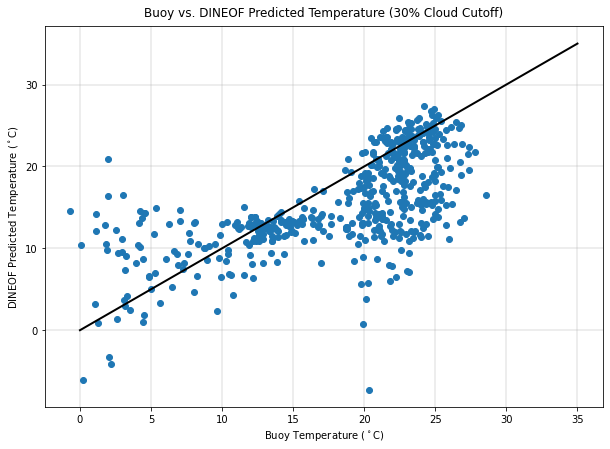

In [ ]:
# plots the dineof predicted data versus the buoy data for all satellites

# filters by cloud cutoff and plots
plot_cloud_cutoff = 30
buoy_data_filtered = np.squeeze(all_buoy_data[:, np.nonzero(all_clouds > plot_cloud_cutoff)],1)
dineof_data_filtered = np.squeeze(all_dineof_data[:, np.nonzero(all_clouds > plot_cloud_cutoff)],1)
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(buoy_data_filtered, dineof_data_filtered);
ax.plot([0,35],[0,35], c='black', lw=2);
plt.title("Buoy vs. DINEOF Predicted Temperature (" + str(plot_cloud_cutoff) + "% Cloud Cutoff)", pad = 10);
plt.xlabel("Buoy Temperature ($^\circ$C)");
plt.ylabel("DINEOF Predicted Temperature ($^\circ$C)");
ax.set_axisbelow(True)
plt.grid(lw=0.45)

Mean: 0.670021493654758
Standard Deviation: 3.2772927056047525
Skewness: 1.2524348409545742
Kurtosis: 6.55012115364949


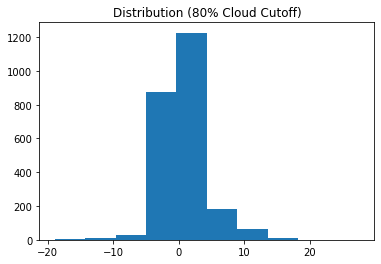

In [ ]:
# calculates statistics for the difference between the predicted dineof
# data and the buoy data for all satellites

# filters by cloud cutoff and calculates statistics
buoy_data_filtered = np.squeeze(all_buoy_data[:, np.nonzero(all_clouds < plot_cloud_cutoff)],1)
dineof_data_filtered = np.squeeze(all_dineof_data[:, np.nonzero(all_clouds < plot_cloud_cutoff)],1)
difference = (buoy_data_filtered-dineof_data_filtered).flatten()
mean_val = np.nanmean(difference)
std_val = np.nanstd(difference)
skew_val = sci.skew(difference, nan_policy='omit')
kurtosis_val = sci.kurtosis(difference, nan_policy='omit')
print('Mean: ' + str(mean_val))
print('Standard Deviation: ' + str(std_val))
print('Skewness: ' + str(skew_val))
print('Kurtosis: ' + str(kurtosis_val))
plt.hist(difference)
plt.title('Distribution (' + str(plot_cloud_cutoff) + "% Cloud Cutoff)");

In [ ]:
# creates the metadata file for the completed product
dates_to_sort = [dt.strptime(date, "%Y-%m-%d") for date in all_dates]
sort_indices = np.argsort(dates_to_sort)
all_dates_sorted = all_dates[sort_indices]
all_clouds_sorted = all_clouds[sort_indices]
all_markers_sorted = all_markers[sort_indices]
metadata = np.empty((len(all_dates_sorted) + 1, 3), dtype="<U20")
metadata[0,:] = ["date", "% cloud cover", "landsat"]
metadata[1:,0] = all_dates_sorted
metadata[1:,1] = all_clouds_sorted
metadata[1:,2] = all_markers_sorted
%cd '/content/drive/MyDrive/Data/Infilled'
np.savetxt("metadata.csv", metadata, delimiter=",", fmt='%s')

/content/drive/MyDrive/Data/Infilled
